### 1. Import libraries and get data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Load the dataset
df = pd.read_csv("./ETH.csv")
df = df.reset_index()['Price']
df

0       1736.45
1       1752.80
2       1751.56
3       1840.41
4       1845.68
         ...   
2218      88.17
2219      92.56
2220      90.37
2221      89.90
2222      86.99
Name: Price, Length: 2223, dtype: float64

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))
print(df.shape)

(2223, 1)


### 2. Split the data into training, test and validate sets

In [20]:
train_size = int(0.7 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1556, 1)
Test shape: (333, 1)
Validate shape: (334, 1)


In [21]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1333, 1)
Test shape: (444, 1)
Validate shape: (446, 1)


In [22]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1556, 1)
Test shape: (444, 1)
Validate shape: (223, 1)


In [23]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_val, y_val = create_dataset(val_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", x_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", x_test.shape)
print("y_test", y_test.shape)

X_train:  (1455, 100)
y_train:  (1455,)
X_val:  (122, 100)
y_val:  (122,)
X_test:  (343, 100)
y_test (343,)


## 3. Perform GBT Model

### 3.1 Build and fit GBT Model with train data

In [25]:
gbt_model = GradientBoostingRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=3,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state=42)
gbt_model.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=2000, random_state=42)

### 3.2 Evaluate on Validate data

In [26]:
def evaludate_gbt_model(x_data, y_data):
    predictions = gbt_model.predict(x_data)
    mse = mean_squared_error(y_data, predictions)
    mae = mean_absolute_error(y_data, predictions)
    mape = mean_absolute_percentage_error(y_data, predictions)
    rmse = mean_squared_error(y_data, predictions, squared=False)
    return predictions, mse, mae, mape, rmse

In [27]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaludate_gbt_model(x_val, y_val)

### 3.3 Evaluate on Test data

In [28]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaludate_gbt_model(x_test, y_test)

### 3.4 Predict price for the next 30 days

In [29]:
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = gbt_model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = gbt_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.1143245]
2 day output [0.10770248]
3 day output [0.10121058]
4 day output [0.10652131]
5 day output [0.09661417]
6 day output [0.09613583]
7 day output [0.10675687]
8 day output [0.09855584]
9 day output [0.09882455]
10 day output [0.09770559]
11 day output [0.09494442]
12 day output [0.09935145]
13 day output [0.10233151]
14 day output [0.09842383]
15 day output [0.09322391]
16 day output [0.09202947]
17 day output [0.09152004]
18 day output [0.09355539]
19 day output [0.09459676]
20 day output [0.09501723]
21 day output [0.09199346]
22 day output [0.09107469]
23 day output [0.09134377]
24 day output [0.09102127]
25 day output [0.09045709]
26 day output [0.09171557]
27 day output [0.09176792]
28 day output [0.0902997]
29 day output [0.09006189]
Output of predicted next days:  [0.12130328922979748, 0.11432449521823877, 0.10770247826090934, 0.1012105759383352, 0.10652130712208475, 0.09661417278264049, 0.09613582612364156, 0.10675687377872162, 0.09855583614898857, 0.09882

In [30]:
y_pred_test = y_pred_test.reshape(-1,1)
y_pred_val = y_pred_val.reshape(-1,1)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

print("Test data prediction:", y_pred_test.shape)
print("Val data prediction:", y_pred_val.shape)

Test data prediction: (343, 1)
Val data prediction: (122, 1)


In [31]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

               MSE       MAE      MAPE      RMSE
Validate  0.000052  0.005878  0.602983  0.007187
Test      0.001803  0.029551  0.269734  0.042459


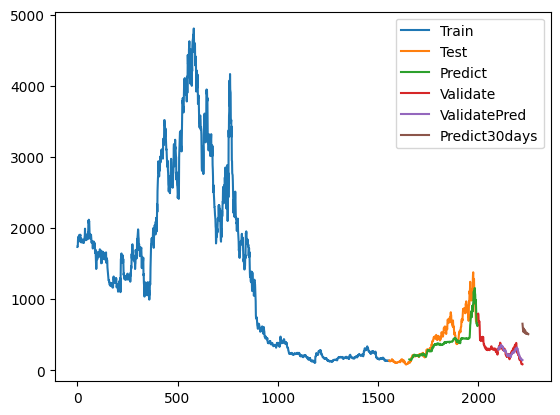

In [32]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_test)

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()